In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math 
import astropy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import scipy.stats as sps

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import statsmodels.api as sm

In [2]:
#SciServer Modules
import SciServer
from SciServer import CasJobs

In [3]:
Candidates = """select drp.MaNGAid,
                drp.nsa_elpetro_mass as GalMass,
                drp.z,
                drp.nsa_elpetro_absmag_u as uMag, 
                drp.nsa_elpetro_absmag_r as rMag,
                firefly.LW_AGE_1RE as LWStellarAge
                
                
                from mangaDRPall as drp
                
                JOIN mangaDAPall as dap on dap.mangaid = drp.mangaid

                JOIN mangaFirefly_mastar as firefly on drp.mangaid = firefly.MANGAID
                                
                WHERE (drp.z < 0.15) and (drp.z > 0.001) 
                and dap.daptype = 'HYB10-MILESHC-MASTARHC2' 
                and (drp.nsa_elpetro_mass > 5e+9)"""

Massives = CasJobs.executeQuery(Candidates, 'dr17')
print(Massives)

CandidateIDs = Massives['MaNGAid']
CandidateMasses = Massives['GalMass']
CandidateZs = Massives['z']
CandidateMags = Massives['uMag'] - Massives['rMag']
lwCandidateAges = Massives['LWStellarAge']

       MaNGAid       GalMass         z      uMag      rMag  LWStellarAge
0     1-380000  3.599260e+10  0.029712 -18.72890 -20.99000      0.678032
1     1-605069  1.084220e+10  0.027750 -17.89960 -19.89840      0.514385
2      1-54587  2.792520e+11  0.148553 -20.29140 -23.22970      0.479961
3     1-457017  7.633190e+09  0.038107 -18.92967 -20.07855      0.129973
4     1-591101  9.592511e+09  0.024526 -17.21661 -19.57203      0.765537
...        ...           ...       ...       ...       ...           ...
7700  1-294999  8.368850e+09  0.041467 -16.99740 -19.42630      0.799078
7701  1-295446  7.130980e+09  0.042697 -17.32140 -19.35770      0.712229
7702  1-324605  8.374630e+09  0.048245 -18.61000 -20.07130      0.229901
7703  1-324790  6.339800e+09  0.039557 -16.75280 -19.12980      0.849614
7704  1-324619  6.878580e+09  0.030806 -17.24370 -19.23840      0.677768

[7705 rows x 6 columns]


In [4]:
#List of ID, Galaxy Mass, z, Magnitude, and Average Stellar Age for all Candidates

ID = []
GalMass = []
Redshift =[]
GalMag = []
lwAvgStelAge = []
GALINFO_RAW = []

for i in range(len(CandidateIDs)):
    ID.append([CandidateIDs[i]])

for i in range(len(CandidateMasses)):
    GalMass.append([CandidateMasses[i]])
    
for i in range(len(CandidateZs)):
    Redshift.append([CandidateZs[i]])

for i in range(len(CandidateMags)):
    GalMag.append([CandidateMags[i]])

for i in range(len(lwCandidateAges)):
    lwAvgStelAge.append([lwCandidateAges[i]])
    
print('No. of MaNGA IDs: ' + str(len(ID)))
print('No. of Galaxy Mass Values: ' + str(len(GalMass)))
print('No. of Redshift Values: ' + str(len(Redshift)))
print('No. of Magnitude Values: ' + str(len(GalMag)))
print('No. of Stellar Age Values: ' + str(len(lwAvgStelAge)) + '\n')

for i in range(len(CandidateIDs)):
    GALINFO_RAW.append([CandidateIDs[i]])
    GALINFO_RAW.append([CandidateMasses[i]])
    GALINFO_RAW.append([CandidateZs[i]])
    GALINFO_RAW.append([CandidateMags[i]])
    GALINFO_RAW.append([lwCandidateAges[i]])

print(GALINFO_RAW)

No. of MaNGA IDs: 7705
No. of Galaxy Mass Values: 7705
No. of Redshift Values: 7705
No. of Magnitude Values: 7705
No. of Stellar Age Values: 7705

[['1-380000'], [35992600000.0], [0.0297122], [2.261099999999999], [0.6780319], ['1-605069'], [10842200000.0], [0.0277501], [1.9987999999999992], [0.5143853], ['1-54587'], [279252000000.0], [0.148553], [2.9383000000000017], [0.4799611], ['1-457017'], [7633190000.0], [0.038107], [1.1488799999999983], [0.1299733], ['1-591101'], [9592511000.0], [0.02452595], [2.3554200000000023], [0.7655369], ['1-154049'], [20188680000.0], [0.05170633], [2.6338500000000025], [0.6084139], ['1-604873'], [13160710000.0], [0.02960716], [1.43046], [0.2949789], ['1-459618'], [7522609000.0], [0.02967112], [1.9660100000000007], [0.2298594], ['1-459215'], [54262690000.0], [0.0843183], [2.2666000000000004], [0.3855784], ['1-83393'], [33105420000.0], [0.02857427], [2.43468], [0.8481149], ['1-593533'], [101425500000.0], [0.02769253], [2.5021500000000003], [0.7876565], ['1-3

In [5]:
##========================================================AGN SORTING=========================================================##

In [6]:
#Creating list of massive galaxy AGN IDs
AGNIDs_DF = pd.read_excel('Massive_AGN_ID.xlsx')
AGNIDs = pd.DataFrame(AGNIDs_DF)
AGNIDs = AGNIDs.values.tolist()

AGNID = []

for i in range(len(AGNIDs)):
    AGNID.append(AGNIDs[i])
    
print('Target number of AGN Galaxies: ' + str(len(AGNID)) + '\n')
print('MaNGA IDs: ' + str(AGNID))

Target number of AGN Galaxies: 4312

MaNGA IDs: [['1-382273'], ['1-382697'], ['1-351913'], ['1-352063'], ['1-352403'], ['1-232167'], ['1-280180'], ['1-3087'], ['1-301609'], ['1-197677'], ['1-320614'], ['1-244998'], ['1-24041'], ['1-23647'], ['1-122595'], ['1-270170'], ['1-543686'], ['1-591782'], ['1-175853'], ['1-70386'], ['1-14039'], ['1-13738'], ['1-200530'], ['1-195761'], ['1-195268'], ['1-497670'], ['1-560607'], ['1-35523'], ['1-108765'], ['1-32786'], ['1-563951'], ['1-41597'], ['1-339092'], ['1-44487'], ['1-383171'], ['1-380300'], ['1-61633'], ['1-79751'], ['1-389513'], ['1-606057'], ['1-301461'], ['1-245301'], ['1-23938'], ['1-153995'], ['1-272795'], ['1-272795'], ['1-269904'], ['1-55170'], ['1-14136'], ['1-82717'], ['1-70173'], ['1-210864'], ['1-211277'], ['1-337227'], ['1-594681'], ['1-40697'], ['1-601919'], ['1-409435'], ['1-2469'], ['1-2921'], ['1-419023'], ['1-107841'], ['1-191503'], ['1-179747'], ['1-180537'], ['1-180497'], ['1-113343'], ['1-37213'], ['1-36903'], ['1-603795

In [7]:
AGN_ID = []
AGN_GalMass = []
AGN_Redshift = []
AGN_Magnitude = []
AGN_lwAvgStelAge = []

AGN_GalCount = 0 #Number of galaxies

for i in range(len(AGNID)):
    for x in range(len(ID)):
        if (AGNID[i] == ID[x]):
            AGN_ID.append(ID[x])
            AGN_GalMass.append(GalMass[x])
            AGN_Redshift.append(Redshift[x])
            AGN_Magnitude.append(GalMag[x])
            AGN_lwAvgStelAge.append(lwAvgStelAge[x])
            AGN_GalCount+=1
            break
            
print('AGN Dominated Galaxy Count: ' + str(AGN_GalCount))
print('IDs: ' + str(AGN_ID) + '\n')
print('Masses: ' + str(AGN_GalMass) + '\n')
print('Redshifts: ' + str(AGN_Redshift) + '\n')
print('Magnitudes: ' + str(AGN_Magnitude) + '\n')
print('Ages: ' + str(AGN_lwAvgStelAge) + '\n')

AGN Dominated Galaxy Count: 4311
IDs: [['1-382273'], ['1-382697'], ['1-351913'], ['1-352063'], ['1-352403'], ['1-232167'], ['1-280180'], ['1-3087'], ['1-301609'], ['1-197677'], ['1-320614'], ['1-244998'], ['1-24041'], ['1-23647'], ['1-122595'], ['1-270170'], ['1-543686'], ['1-591782'], ['1-175853'], ['1-70386'], ['1-14039'], ['1-13738'], ['1-200530'], ['1-195761'], ['1-195268'], ['1-497670'], ['1-560607'], ['1-35523'], ['1-108765'], ['1-32786'], ['1-563951'], ['1-41597'], ['1-339092'], ['1-44487'], ['1-383171'], ['1-380300'], ['1-61633'], ['1-79751'], ['1-389513'], ['1-606057'], ['1-301461'], ['1-245301'], ['1-23938'], ['1-153995'], ['1-272795'], ['1-272795'], ['1-269904'], ['1-55170'], ['1-14136'], ['1-82717'], ['1-70173'], ['1-210864'], ['1-211277'], ['1-337227'], ['1-594681'], ['1-40697'], ['1-601919'], ['1-409435'], ['1-2469'], ['1-2921'], ['1-419023'], ['1-107841'], ['1-191503'], ['1-179747'], ['1-180537'], ['1-180497'], ['1-113343'], ['1-37213'], ['1-36903'], ['1-603795'], ['1-40

In [8]:
#Removing brackets from element

for i in range(len(AGN_ID)):
    AGN_ID[i] = str(AGN_ID[i])[1:]
    AGN_ID[i] = str(AGN_ID[i])[:-1]
    
for i in range(len(AGN_GalMass)):
    AGN_GalMass[i] = str(AGN_GalMass[i])[1:]
    AGN_GalMass[i] = str(AGN_GalMass[i])[:-1]
    
for i in range(len(AGN_Redshift)):
    AGN_Redshift[i] = str(AGN_Redshift[i])[1:]
    AGN_Redshift[i] = str(AGN_Redshift[i])[:-1]
    
for i in range(len(AGN_Magnitude)):
    AGN_Magnitude[i] = str(AGN_Magnitude[i])[1:]
    AGN_Magnitude[i] = str(AGN_Magnitude[i])[:-1]

for i in range(len(AGN_lwAvgStelAge)):
    AGN_lwAvgStelAge[i] = str(AGN_lwAvgStelAge[i])[1:]
    AGN_lwAvgStelAge[i] = str(AGN_lwAvgStelAge[i])[:-1]
    
print(AGN_ID)
print(AGN_GalMass)
print(AGN_Redshift)
print(AGN_Magnitudes)
print(AGN_lwAvgStelAge)

["'1-382273'", "'1-382697'", "'1-351913'", "'1-352063'", "'1-352403'", "'1-232167'", "'1-280180'", "'1-3087'", "'1-301609'", "'1-197677'", "'1-320614'", "'1-244998'", "'1-24041'", "'1-23647'", "'1-122595'", "'1-270170'", "'1-543686'", "'1-591782'", "'1-175853'", "'1-70386'", "'1-14039'", "'1-13738'", "'1-200530'", "'1-195761'", "'1-195268'", "'1-497670'", "'1-560607'", "'1-35523'", "'1-108765'", "'1-32786'", "'1-563951'", "'1-41597'", "'1-339092'", "'1-44487'", "'1-383171'", "'1-380300'", "'1-61633'", "'1-79751'", "'1-389513'", "'1-606057'", "'1-301461'", "'1-245301'", "'1-23938'", "'1-153995'", "'1-272795'", "'1-272795'", "'1-269904'", "'1-55170'", "'1-14136'", "'1-82717'", "'1-70173'", "'1-210864'", "'1-211277'", "'1-337227'", "'1-594681'", "'1-40697'", "'1-601919'", "'1-409435'", "'1-2469'", "'1-2921'", "'1-419023'", "'1-107841'", "'1-191503'", "'1-179747'", "'1-180537'", "'1-180497'", "'1-113343'", "'1-37213'", "'1-36903'", "'1-603795'", "'1-40980'", "'1-40936'", "'1-42381'", "'1-5

NameError: name 'AGN_Magnitudes' is not defined

In [9]:
#Information is stored in a 4D array detailed below

                             #**SO FAR ONLY MANGA ID, GALAXY MASS, AND REDSHIFT ARE IN THE LIST**# 
                    ########################################################################################                 
                    #                                                                                      #
                    # #==========INDEX-0=====INDEX-1======INDEX-2=======INDEX-3=============INDEX-4        #
                    #                                                                                      #
                    # #INDEX-0  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-1  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-2  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX...                                                                            #
                    ########################################################################################           
                        
AGN_GALAXIES_CONDENSED = np.array(list(zip(AGN_ID, AGN_GalMass, AGN_Redshift, AGN_Magnitude, AGN_lwAvgStelAge)))
AGN_GALAXIES_CONDENSED = pd.DataFrame(AGN_GALAXIES_CONDENSED)
AGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-382273',48899700000.0,0.0460914,1.8465999999999987,0.3054635
1,'1-382697',17505800000.0,0.0364051,2.2799000000000014,0.5694357
2,'1-351913',64299500000.0,0.0831795,2.8874999999999993,0.7754901
3,'1-352063',108517000000.0,0.138558,2.0249999999999986,0.5695607
4,'1-352403',26492100000.0,0.0641308,1.4968000000000004,0.6434294
...,...,...,...,...,...
4306,'1-456981',7694350000.0,0.0274531,2.2833000000000006,0.7862425
4307,'1-294633',10707700000.0,0.0320091,2.100200000000001,0.2673494
4308,'1-294327',26897700000.0,0.0609603,1.6808000000000014,0.3655429
4309,'1-294459',107128000000.0,0.129538,2.349999999999998,0.7066243


In [10]:
#Changing values from strings to floats

for i in range(len(AGN_GALAXIES_CONDENSED)):
    AGN_GALAXIES_CONDENSED[1][i] = float(AGN_GALAXIES_CONDENSED[1][i])
    AGN_GALAXIES_CONDENSED[2][i] = float(AGN_GALAXIES_CONDENSED[2][i])
    AGN_GALAXIES_CONDENSED[3][i] = float(AGN_GALAXIES_CONDENSED[3][i])
    AGN_GALAXIES_CONDENSED[4][i] = float(AGN_GALAXIES_CONDENSED[4][i])
    
AGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-382273',4.88997e+10,0.0460914,1.8466,0.305463
1,'1-382697',1.75058e+10,0.0364051,2.2799,0.569436
2,'1-351913',6.42995e+10,0.0831795,2.8875,0.77549
3,'1-352063',1.08517e+11,0.138558,2.025,0.569561
4,'1-352403',2.64921e+10,0.0641308,1.4968,0.643429
...,...,...,...,...,...
4306,'1-456981',7.69435e+09,0.0274531,2.2833,0.786242
4307,'1-294633',1.07077e+10,0.0320091,2.1002,0.267349
4308,'1-294327',2.68977e+10,0.0609603,1.6808,0.365543
4309,'1-294459',1.07128e+11,0.129538,2.35,0.706624


In [11]:
##======================================================NON-AGN SORTING=======================================================##

In [12]:
#Creating list of massive galaxy NON-AGN IDs
SFIDs_DF = pd.read_excel('Massive_SF_ID.xlsx')
SFIDs = pd.DataFrame(SFIDs_DF)
SFIDs = SFIDs.values.tolist()

SFID = []

for i in range(len(SFIDs)):
    SFID.append(SFIDs[i])
    
print('Target number of SF Galaxies: ' + str(len(SFID)) + '\n')
print('MaNGA IDs: ' + str(SFID))

Target number of SF Galaxies: 1466

MaNGA IDs: [['1-351890'], ['1-245268'], ['1-625977'], ['1-195737'], ['1-325495'], ['1-35371'], ['1-35716'], ['1-2456'], ['1-401748'], ['1-32701'], ['1-120074'], ['1-113346'], ['1-113273'], ['1-42340'], ['1-44083'], ['1-321148'], ['1-245560'], ['1-25690'], ['1-122206'], ['1-319368'], ['1-319368'], ['1-82991'], ['1-394046'], ['1-420973'], ['1-180513'], ['1-36476'], ['1-231412'], ['1-78358'], ['1-52936'], ['1-95220'], ['1-27443'], ['1-118005'], ['1-118202'], ['1-2988'], ['1-97179'], ['1-596366'], ['1-212420'], ['1-338963'], ['1-300739'], ['1-522187'], ['1-458664'], ['1-1009'], ['1-211790'], ['1-35709'], ['1-35729'], ['1-386400'], ['1-210415'], ['1-178265'], ['1-41257'], ['1-582721'], ['1-122708'], ['1-383'], ['1-319381'], ['1-605788'], ['1-80655'], ['1-395813'], ['1-109679'], ['1-180135'], ['1-550950'], ['1-113587'], ['1-73002'], ['1-217695'], ['1-217650'], ['1-591528'], ['1-603920'], ['1-217331'], ['1-590053'], ['1-605884'], ['1-278490'], ['1-95770'], 

In [13]:
nonAGN_ID = []
nonAGN_GalMass = []
nonAGN_Redshift = []
nonAGN_Magnitude = []
nonAGN_lwAvgStelAge = []


nonAGN_GalCount = 0 #Number of galaxies

for i in range(len(SFID)):
    for x in range(len(ID)):
        if (SFID[i] == ID[x]):
            nonAGN_ID.append(ID[x])
            nonAGN_GalMass.append(GalMass[x])
            nonAGN_Redshift.append(Redshift[x])
            nonAGN_Magnitude.append(GalMag[x])
            nonAGN_lwAvgStelAge.append(lwAvgStelAge[x])
            nonAGN_GalCount+=1
            break
            
print('SF Dominated Galaxy Count: ' + str(nonAGN_GalCount))
print('IDs' + str(nonAGN_ID) + '\n')
print('Masses' + str(nonAGN_GalMass) + '\n')
print('Redshifts' + str(nonAGN_Redshift) + '\n')
print('Magnitudes: ' + str(nonAGN_Magnitude) + '\n')
print('Ages: ' + str(nonAGN_lwAvgStelAge) + '\n')

SF Dominated Galaxy Count: 1466
IDs[['1-351890'], ['1-245268'], ['1-625977'], ['1-195737'], ['1-325495'], ['1-35371'], ['1-35716'], ['1-2456'], ['1-401748'], ['1-32701'], ['1-120074'], ['1-113346'], ['1-113273'], ['1-42340'], ['1-44083'], ['1-321148'], ['1-245560'], ['1-25690'], ['1-122206'], ['1-319368'], ['1-319368'], ['1-82991'], ['1-394046'], ['1-420973'], ['1-180513'], ['1-36476'], ['1-231412'], ['1-78358'], ['1-52936'], ['1-95220'], ['1-27443'], ['1-118005'], ['1-118202'], ['1-2988'], ['1-97179'], ['1-596366'], ['1-212420'], ['1-338963'], ['1-300739'], ['1-522187'], ['1-458664'], ['1-1009'], ['1-211790'], ['1-35709'], ['1-35729'], ['1-386400'], ['1-210415'], ['1-178265'], ['1-41257'], ['1-582721'], ['1-122708'], ['1-383'], ['1-319381'], ['1-605788'], ['1-80655'], ['1-395813'], ['1-109679'], ['1-180135'], ['1-550950'], ['1-113587'], ['1-73002'], ['1-217695'], ['1-217650'], ['1-591528'], ['1-603920'], ['1-217331'], ['1-590053'], ['1-605884'], ['1-278490'], ['1-95770'], ['1-176879']

In [14]:
#Removing brackets from element

for i in range(len(nonAGN_ID)):
    nonAGN_ID[i] = str(nonAGN_ID[i])[1:]
    nonAGN_ID[i] = str(nonAGN_ID[i])[:-1]
    
for i in range(len(nonAGN_GalMass)):
    nonAGN_GalMass[i] = str(nonAGN_GalMass[i])[1:]
    nonAGN_GalMass[i] = str(nonAGN_GalMass[i])[:-1]
    
for i in range(len(nonAGN_Redshift)):
    nonAGN_Redshift[i] = str(nonAGN_Redshift[i])[1:]
    nonAGN_Redshift[i] = str(nonAGN_Redshift[i])[:-1]
    
for i in range(len(nonAGN_Magnitude)):
    nonAGN_Magnitude[i] = str(nonAGN_Magnitude[i])[1:]
    nonAGN_Magnitude[i] = str(nonAGN_Magnitude[i])[:-1]

for i in range(len(nonAGN_lwAvgStelAge)):
    nonAGN_lwAvgStelAge[i] = str(nonAGN_lwAvgStelAge[i])[1:]
    nonAGN_lwAvgStelAge[i] = str(nonAGN_lwAvgStelAge[i])[:-1]
    
print(nonAGN_ID)
print(nonAGN_GalMass)
print(nonAGN_Redshift)
print(nonAGN_Magnitude)
print(nonAGN_lwAvgStelAge)

["'1-351890'", "'1-245268'", "'1-625977'", "'1-195737'", "'1-325495'", "'1-35371'", "'1-35716'", "'1-2456'", "'1-401748'", "'1-32701'", "'1-120074'", "'1-113346'", "'1-113273'", "'1-42340'", "'1-44083'", "'1-321148'", "'1-245560'", "'1-25690'", "'1-122206'", "'1-319368'", "'1-319368'", "'1-82991'", "'1-394046'", "'1-420973'", "'1-180513'", "'1-36476'", "'1-231412'", "'1-78358'", "'1-52936'", "'1-95220'", "'1-27443'", "'1-118005'", "'1-118202'", "'1-2988'", "'1-97179'", "'1-596366'", "'1-212420'", "'1-338963'", "'1-300739'", "'1-522187'", "'1-458664'", "'1-1009'", "'1-211790'", "'1-35709'", "'1-35729'", "'1-386400'", "'1-210415'", "'1-178265'", "'1-41257'", "'1-582721'", "'1-122708'", "'1-383'", "'1-319381'", "'1-605788'", "'1-80655'", "'1-395813'", "'1-109679'", "'1-180135'", "'1-550950'", "'1-113587'", "'1-73002'", "'1-217695'", "'1-217650'", "'1-591528'", "'1-603920'", "'1-217331'", "'1-590053'", "'1-605884'", "'1-278490'", "'1-95770'", "'1-176879'", "'1-457196'", "'1-153589'", "'1-2

In [15]:
#Information is stored in a 4D array detailed below

                             #**SO FAR ONLY MANGA ID, GALAXY MASS, AND REDSHIFT ARE IN THE LIST**# 
                    ########################################################################################                 
                    #                                                                                      #
                    # #==========INDEX-0=====INDEX-1======INDEX-2=======INDEX-3=============INDEX-4        #
                    #                                                                                      #
                    # #INDEX-0  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-1  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-2  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX...                                                                            #
                    ########################################################################################           
                        

nonAGN_GALAXIES_CONDENSED = np.array(list(zip(nonAGN_ID, nonAGN_GalMass, nonAGN_Redshift, nonAGN_Magnitude, nonAGN_lwAvgStelAge)))
nonAGN_GALAXIES_CONDENSED = pd.DataFrame(nonAGN_GALAXIES_CONDENSED)
nonAGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-351890',32939800000.0,0.0697078,1.667399999999997,0.1430905
1,'1-245268',8425032000.0,0.04226217,2.1196599999999997,0.5255152
2,'1-625977',20928680000.0,0.05637577,1.6912900000000022,-0.09896934
3,'1-195737',12600940000.0,0.0298008,1.4516799999999996,0.1015629
4,'1-325495',19496570000.0,0.05426748,-0.23577999999999832,-9999.0
...,...,...,...,...,...
1461,'1-632854',128624000000.0,0.0657099,2.5147000000000013,0.7548943
1462,'1-164336',13859000000.0,0.0489643,2.1136000000000017,0.5285441
1463,'1-197292',64773400000.0,0.0452915,2.4724000000000004,0.7217343
1464,'1-592810',14231700000.0,0.0498245,2.336500000000001,0.6135998


In [16]:
#Changing values from strings to floats

for i in range(len(nonAGN_GALAXIES_CONDENSED)):
    nonAGN_GALAXIES_CONDENSED[1][i] = float(nonAGN_GALAXIES_CONDENSED[1][i])
    nonAGN_GALAXIES_CONDENSED[2][i] = float(nonAGN_GALAXIES_CONDENSED[2][i])
    nonAGN_GALAXIES_CONDENSED[3][i] = float(nonAGN_GALAXIES_CONDENSED[3][i])
    nonAGN_GALAXIES_CONDENSED[4][i] = float(nonAGN_GALAXIES_CONDENSED[4][i])
    
AGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-382273',4.88997e+10,0.0460914,1.8466,0.305463
1,'1-382697',1.75058e+10,0.0364051,2.2799,0.569436
2,'1-351913',6.42995e+10,0.0831795,2.8875,0.77549
3,'1-352063',1.08517e+11,0.138558,2.025,0.569561
4,'1-352403',2.64921e+10,0.0641308,1.4968,0.643429
...,...,...,...,...,...
4306,'1-456981',7.69435e+09,0.0274531,2.2833,0.786242
4307,'1-294633',1.07077e+10,0.0320091,2.1002,0.267349
4308,'1-294327',2.68977e+10,0.0609603,1.6808,0.365543
4309,'1-294459',1.07128e+11,0.129538,2.35,0.706624


In [17]:
print((AGN_GALAXIES_CONDENSED[1][0]))

48899700000.0


In [18]:
##===================================================MATCHING AGN TO NON-AGN==================================================##

In [23]:
AGN_PAIR_HALFS_LW = []
nonAGN_PAIR_HALFS_LW = []

MassThreshold = 0.1
zThreshold = 0.05
MagThreshold = 0.25

PairCount = 0

for i in range(len(AGN_GALAXIES_CONDENSED)):
    for x in range(len(nonAGN_GALAXIES_CONDENSED)):
        if ((nonAGN_GALAXIES_CONDENSED[4][x] not in nonAGN_PAIR_HALFS_LW)
                and
            ((AGN_GALAXIES_CONDENSED[4][i] > -1) and (nonAGN_GALAXIES_CONDENSED[4][x] > -1))
                and
            (((AGN_GALAXIES_CONDENSED[1][i]) - (AGN_GALAXIES_CONDENSED[1][i] * MassThreshold)) <= nonAGN_GALAXIES_CONDENSED[1][x] <= ((AGN_GALAXIES_CONDENSED[1][i]) + (AGN_GALAXIES_CONDENSED[1][i] * MassThreshold)))
                and 
            (((AGN_GALAXIES_CONDENSED[2][i]) - (AGN_GALAXIES_CONDENSED[2][i] * zThreshold)) <= nonAGN_GALAXIES_CONDENSED[2][x] <= ((AGN_GALAXIES_CONDENSED[2][i]) + (AGN_GALAXIES_CONDENSED[2][i] * zThreshold)))
                and
            (((AGN_GALAXIES_CONDENSED[3][i]) - (AGN_GALAXIES_CONDENSED[3][i] * MagThreshold)) <= nonAGN_GALAXIES_CONDENSED[3][x] <= ((AGN_GALAXIES_CONDENSED[3][i]) + (AGN_GALAXIES_CONDENSED[3][i] * MagThreshold)))
           ):
            
            AGN_PAIR_HALFS_LW.append(AGN_GALAXIES_CONDENSED[4][i])
            nonAGN_PAIR_HALFS_LW.append(nonAGN_GALAXIES_CONDENSED[4][x])
            PairCount +=1
            break

PercentMatched = (PairCount/AGN_GalCount)*100
            
print('Total AGN/Non-AGN Galaxy Pairs: ' + str(PairCount))
print('Percentage of AGN Galaxies Paried: %.3f' % PercentMatched)

Total AGN/Non-AGN Galaxy Pairs: 1368
Percentage of AGN Galaxies Paried: 31.733


In [27]:
COMPLETE_PAIRS_LW = (AGN_PAIR_HALFS_LW, nonAGN_PAIR_HALFS_LW)

print('No. of AGN Pair Halfs: ' + str(len(AGN_PAIR_HALFS_LW)))
print('No. of SF Pair Halfs: ' + str(len(nonAGN_PAIR_HALFS_LW)) + '\n')
print('List of Both Halfs: ' + str(COMPLETE_PAIRS_LW))

No. of AGN Pair Halfs: 1368
No. of SF Pair Halfs: 1368

List of Both Halfs: ([0.3054635, 0.5694357, 0.7754901, 0.5695607, 0.6434294, 0.7310468, 0.54229, 0.4723158, 0.731791, 0.8716323, 0.4829682, 0.852132, 0.6873326, 0.4003298, 0.781637, 0.7875857, 0.7752565, 0.9366407, 0.7692733, 0.6526971, 0.7823106, 0.5846526, 0.4074249, 0.6303914, 0.6953256, 0.6671239, 0.7394062, 0.6589321, 0.7492206, 0.8393841, 0.5974309, 0.445059, 0.4090627, 0.5795736, 0.5714236, 0.8481911, 0.8597786, 0.6567799, 0.8019309, 0.8771963, 0.7804354, 0.7804354, 0.8391135, 0.5836225, 0.6184139, 0.6660742, 0.4604191, 0.4357949, 0.5385457, 0.7049591, 0.2840489, 0.8448264, 0.6652389, 0.5630624, 0.7989061, 0.8156742, 0.8333576, 0.185466, 0.5120074, 0.1808479, 0.724337, 0.8662011, 0.3641927, 0.8289995, 0.6929335, 0.7772652, 0.8108016, 0.8667082, 0.7379606, 0.6490322, 0.2946073, 0.5644678, 0.8060468, 0.7549683, 0.2836775, 0.5523447, 0.7082527, 0.343313, 0.7062195, 0.3950314, 0.5538331, 0.8215994, 0.2060378, -0.9486765, 0.5400

In [28]:
#Creating Excel files for Complete Pair Data
from openpyxl import Workbook
import xlsxwriter

#Light Weighted AGN Pairs
m_AGNLWExcel = pd.DataFrame({"Massive AGN LW Stellar Population Age Data": AGN_PAIR_HALFS_LW})
m_AGNLWExcel.to_excel("MASSIVE_AGN_LW_StelAgeData.xlsx", index=False)

#Light Weighted SF Pairs
m_SFLWExcel = pd.DataFrame({"Massive SF LW Stellar Population Age Data": nonAGN_PAIR_HALFS_LW})
m_SFLWExcel.to_excel("MASSIVE_SF_LW_StelAgeData.xlsx", index=False)

#Mass Weighted SF Pairs
#m_AGNMWExcel = pd.DataFrame({"Massive AGN MW Stellar Population Age Data": AGN_PAIRS_MW})
#m_AGNMWExcel.to_excel("MASSIVE_AGN_MW_StelAgeData.xlsx", index=False)

#Mass Weighted SF Pairs
#m_SFMWExcel = pd.DataFrame({"Massive SF MW Stellar Population Age Data": SF_PAIRS_MW})
#m_SFMWExcel.to_excel("MASSIVE_SF_MW_StelAgeData.xlsx", index=False)

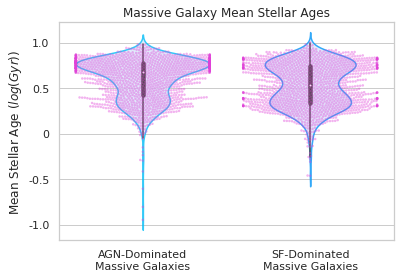

In [34]:
alphas = [0.8, 0.8]
facecolor = ['#D9E7FA','#D9E7FA']
edgecolors = ['#02BEF7','#0295F7']

sns.set(style = 'whitegrid') 

vlnplt = sns.violinplot(data = COMPLETE_PAIRS_LW)
plt.yticks([-1.0, -0.5, 0, 0.5, 1.0], ['-1.0', '-0.5','0', '0.5', '1.0'])

for violin, alpha in zip(vlnplt.collections[::2], alphas):
    violin.set_alpha(alpha)
    
for pc, color in zip(vlnplt.collections[::2], facecolor):
    pc.set_facecolor(color)

for pc, color in zip(vlnplt.collections[::2], edgecolors):
    pc.set_edgecolor(color)
    
    
srmplt = sns.swarmplot(data = COMPLETE_PAIRS_LW, alpha = 0.4, s = 2.5, color = '#E041D8')
srmplt.set_ylabel("Mean Stellar Age " + "$(log(Gyr))$")
srmplt.set_title("Massive Galaxy Mean Stellar Ages")
srmplt.set_xticklabels(['AGN-Dominated\nMassive Galaxies', 'SF-Dominated\nMassive Galaxies'])

plt.savefig('Massive Galaxy Stellar Population Age', dpi = 600, bbox_inches = 'tight')

In [ ]:
##=====================================================STATISTICAL ANALYSIS===================================================##

In [31]:
sps.ks_2samp(AGN_PAIR_HALFS_LW, nonAGN_PAIR_HALFS_LW)

KstestResult(statistic=0.16885964912280702, pvalue=1.9298814805095228e-17)

In [32]:
sps.ttest_i(AGN_PAIR_HALFS_LW, nonAGN_PAIR_HALFS_LW)

Ttest_indResult(statistic=7.861898677311229, pvalue=5.397425314341499e-15)